In [111]:
import pandas as pd

numerical_df = pd.read_csv("../dataset/cleaned_numerical_data.csv")
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 45 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [112]:
#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 43)
Theoretical df shape: (105589, 43)


In [113]:
real_df['band_gap'].describe()
#Note, band_gap is not normally distributed and is skewed right

count    49772.000000
mean         1.341899
std          1.739477
min          0.000000
25%          0.000000
50%          0.265150
75%          2.443400
max         17.891400
Name: band_gap, dtype: float64

In [114]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49772 entries, 36 to 155336
Data columns (total 43 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   nsites                                        49772 non-null  int64  
 1   nelements                                     49772 non-null  int64  
 2   volume                                        49772 non-null  float64
 3   density                                       49772 non-null  float64
 4   density_atomic                                49772 non-null  float64
 5   energy_per_atom                               48674 non-null  float64
 6   formation_energy_per_atom                     48674 non-null  float64
 7   energy_above_hull                             48674 non-null  float64
 8   is_stable                                     49772 non-null  int64  
 9   equilibrium_reaction_energy_per_atom          23056 non-null  fl

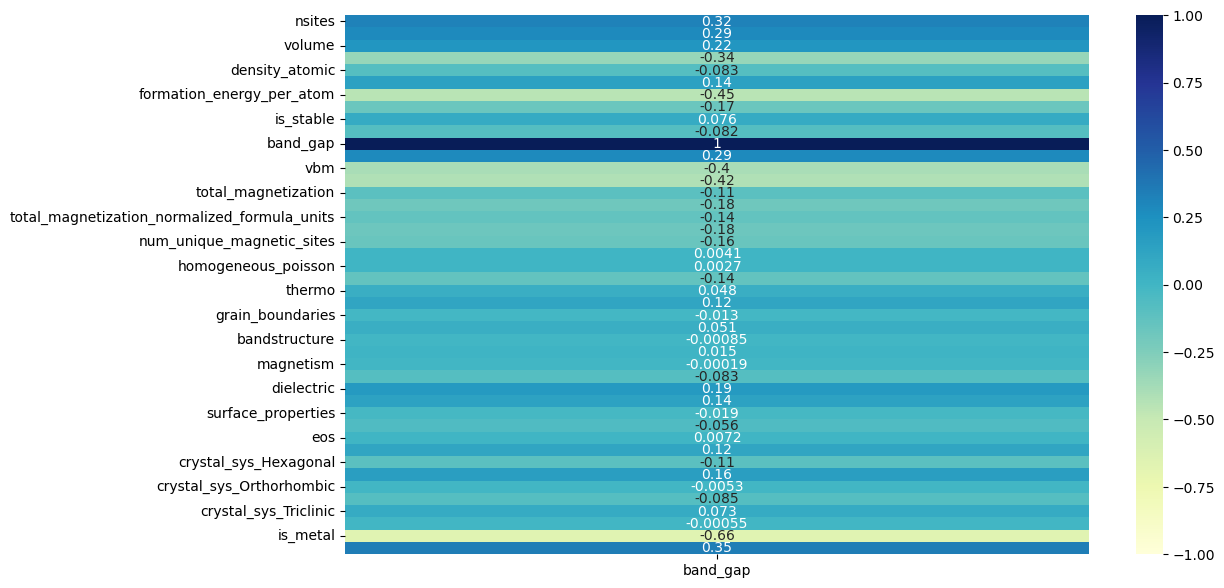

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['band_gap']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [116]:
from sklearn.model_selection import train_test_split

# Create the list of features to train with below
feature_names = ["nsites", "nelements", "is_gap_direct",
                 "energy_per_atom", "is_metal","efermi" ,"vbm" ,"cbm","formation_energy_per_atom","density"]
filtered_null_counts = numerical_df.loc[numerical_df['theoretical'] == 1, feature_names].isnull().sum()

print(filtered_null_counts) #Tree and Forrest Models can handle null values - so we wont touch nulls

# # Other option 
# theoretical_df[feature_names] = theoretical_df[feature_names].fillna(theoretical_df[feature_names].mean())

X = real_df[feature_names]
y = real_df["band_gap"]
train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

#Get train, test and theoretical sets:
theoretical_df = theoretical_df.dropna(subset=['band_gap'])
theoretical_x = theoretical_df[feature_names]
theoretical_y = theoretical_df['band_gap']

nsites                           0
nelements                        0
is_gap_direct                    0
energy_per_atom               2114
is_metal                         0
efermi                          17
vbm                          43644
cbm                          43644
formation_energy_per_atom     2114
density                          0
dtype: int64


In [117]:
from sklearn.tree import DecisionTreeRegressor

dtr_model = DecisionTreeRegressor(random_state=1)
dtr_model.fit(train_X, train_y)

DecisionTreeRegressor(random_state=1)

In [118]:
#Tree Model on Traina and Test Set

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

#Train Data
predictions = dtr_model.predict(train_X)
r2 = r2_score(train_y, predictions)
mse = mean_squared_error(train_y, predictions)
mae = mean_absolute_error(train_y, predictions)
print(f"Tree Model Train Set Metrics:\nR-squared: {r2}\nMean Squared Error: {mse}\nMean Absolute Error: {mae}\n\n---\n\n")


#Test Data
predictions = dtr_model.predict(test_x)
r2 = r2_score(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
print(f"Tree Model Test Set Metrics:\nR-squared: {r2}\nMean Squared Error: {mse}\nMean Absolute Error: {mae}")

Tree Model Train Set Metrics:
R-squared: 0.9999998496388429
Mean Squared Error: 4.5821880650993516e-07
Mean Absolute Error: 1.0940325497287656e-05

---


Tree Model Test Set Metrics:
R-squared: 0.988389069597038
Mean Squared Error: 0.035067144296047015
Mean Absolute Error: 0.07111701742930333


In [119]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=20, oob_score=True)
rfr.fit(train_X, train_y)

RandomForestRegressor(n_estimators=20, oob_score=True)

In [120]:
#RFR Model Train Data Metrics
predictions = rfr.predict(train_X)
r2 = r2_score(train_y, predictions)
mse = mean_squared_error(train_y, predictions)
mae = mean_absolute_error(train_y, predictions)
oob = rfr.oob_score_
print(f"Random Forrest Regressor - Train Set Metrics:\nR-squared: {r2}\nMean Squared Error: {mse}\nMean Absolute Error: {mae}\n\n---\n\n")

#RFR Model Test data Metrics
predictions = rfr.predict(test_x)
r2 = r2_score(test_y, predictions)
mse = mean_squared_error(test_y, predictions)
mae = mean_absolute_error(test_y, predictions)
print(f"Random Forrest Regressor - Test Set Metrics:\nR-squared: {r2}\nMean Squared Error: {mse}\nMean Absolute Error: {mae}\n\n---\n\n")

#RFR Model Theoretical data Metrics
predictions = rfr.predict(theoretical_x)
r2 = r2_score(theoretical_y, predictions)
mse = mean_squared_error(theoretical_y, predictions)
mae = mean_absolute_error(theoretical_y, predictions)
print(f"Random Forrest Regressor - Theoretical Set Metrics:\nR-squared: {r2}\nMean Squared Error: {mse}\nMean Absolute Error: {mae}\n\n---\n\n")



Random Forrest Regressor - Train Set Metrics:
R-squared: 0.9994910741581047
Mean Squared Error: 0.0015509284210769537
Mean Absolute Error: 0.016086218605585696 OOB Score: 0.9963403470970795

---


Random Forrest Regressor - Test Set Metrics:
R-squared: 0.9934186612237366
Mean Squared Error: 0.019876852975496635
Mean Absolute Error: 0.036192970390275754

---


Random Forrest Regressor - Theoretical Set Metrics:
R-squared: 0.9913487832248705
Mean Squared Error: 0.015493192902428232
Mean Absolute Error: 0.040806340487398306

---


